In [1]:
import tensorflow as tf
print("imported")

imported


In [2]:
import numpy as np

In [3]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check GPU information
print("GPU devices:", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
TensorFlow version: 2.10.1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


In [5]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [23]:

def multi_unet_model(n_classes=11, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    
    return model
   

In [24]:
SIZE_X = 256
SIZE_Y = 256
n_classes=11 #Number of classes for segmentation
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("D:/cources/Internship/2023/ASDC AI & Data analysis internship/dataset/semantic segmentation/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, 0) 
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

In [25]:
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
train_images.shape

(100, 256, 256)

In [26]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("D:/cources/Internship/2023/ASDC AI & Data analysis internship/dataset/semantic segmentation/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.jpg___fuse.png")): #.jpg___save.png
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)


In [27]:
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
train_masks.shape

(100, 256, 256)

In [28]:
np.unique(train_masks)

array([  0,  66,  79,  90,  96, 129, 169, 170, 191, 213, 214], dtype=uint8)

In [29]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)


In [30]:
train_masks_reshaped_encoded

array([3, 3, 3, ..., 5, 5, 5], dtype=int64)

In [31]:
np.unique(train_masks_encoded_original_shape)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [32]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_images.shape

(100, 256, 256, 1)

In [33]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
train_masks_input.shape

(100, 256, 256, 1)

In [34]:
from sklearn.model_selection import train_test_split
#Further split training data t a smaller subset for quick testing of models
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.2, random_state = 0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(80, 256, 256, 1) (20, 256, 256, 1) (80, 256, 256, 1) (20, 256, 256, 1)


In [35]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
y_train_cat.shape

(80, 256, 256, 11)

In [36]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
y_test_cat.shape

(20, 256, 256, 11)

In [37]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [38]:
 X_train.shape

(80, 256, 256, 1)

In [39]:
 model= multi_unet_model(n_classes=n_classes,
                        IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH,
                        IMG_CHANNELS=IMG_CHANNELS)

In [40]:
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [41]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()
metrics=['accuracy', jacard_coef]
# model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_5 (Dropout)            (None, 256, 256, 16  0           ['conv2d_10[0][0]']              
                                )                                                             

In [43]:
model.load_weights('test.hdf5')
history = model.fit(X_train, y_train_cat, 
                    batch_size=16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/50
5/5 [==============================] - 36s 7s/step - loss: 0.9117 - accuracy: 0.8301 - jacard_coef: 0.6891 - val_loss: 0.5958 - val_accuracy: 0.8525 - val_jacard_coef: 0.7070
Epoch 2/50
5/5 [==============================] - 37s 7s/step - loss: 0.5662 - accuracy: 0.8379 - jacard_coef: 0.6533 - val_loss: 0.5551 - val_accuracy: 0.8548 - val_jacard_coef: 0.6309
Epoch 3/50
5/5 [==============================] - 39s 8s/step - loss: 0.4772 - accuracy: 0.8523 - jacard_coef: 0.6259 - val_loss: 0.3930 - val_accuracy: 0.8882 - val_jacard_coef: 0.6984
Epoch 4/50
5/5 [==============================] - 38s 8s/step - loss: 0.3987 - accuracy: 0.8762 - jacard_coef: 0.6880 - val_loss: 0.3370 - val_accuracy: 0.8959 - val_jacard_coef: 0.7428
Epoch 5/50
5/5 [==============================] - 35s 7s/step - loss: 0.3542 - accuracy: 0.8848 - jacard_coef: 0.7180 - val_loss: 0.3309 - val_accuracy: 0.8983 - val_jacard_coef: 0.7429
Epoch 6/50
5/5 [==============================] - 37s 7s/step - loss: 

In [40]:
# model.save('test.hdf5')


In [46]:
_ ,jacard_coef, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")
print("jacard_coef is = ", jacard_coef)

1/1 [==============================] - 0s 420ms/step - loss: 0.2486 - accuracy: 0.9332 - jacard_coef: 0.8484
Accuracy is =  84.8350465297699 %
jacard_coef is =  0.9332138299942017


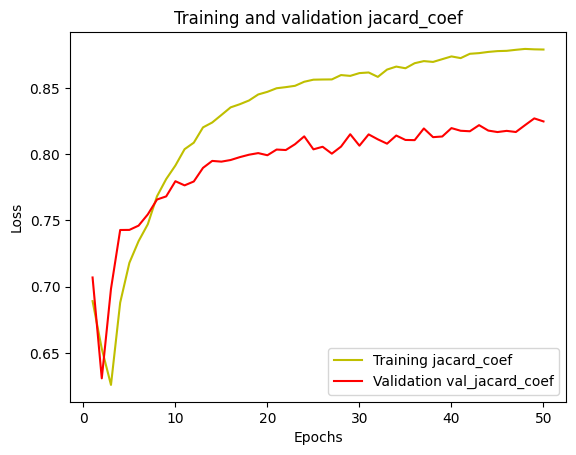

In [49]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['jacard_coef']
val_loss = history.history['val_jacard_coef']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training jacard_coef')
plt.plot(epochs, val_loss, 'r', label='Validation val_jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

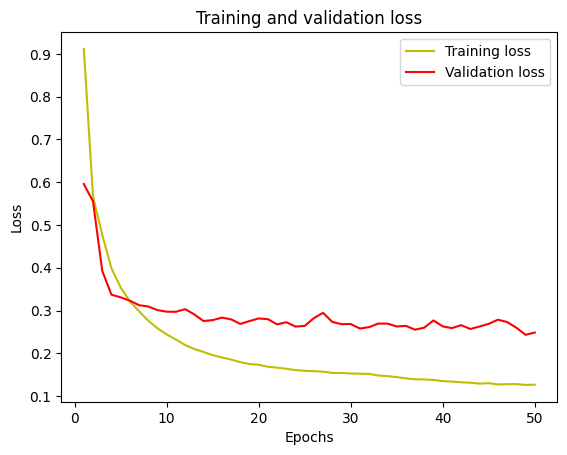

In [47]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

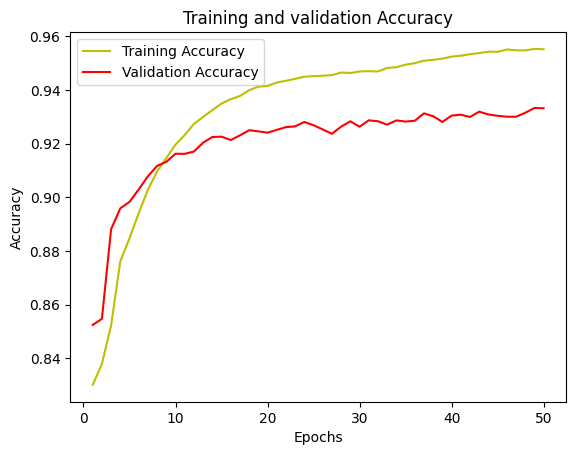

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 [==============================] - 1s 627ms/step


In [52]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 11
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.51009583


CLASS DISTRIBUTION.
Classes Instances Count Concentration Ratio
Team B 210 23%
Team A 192 21%
Advertisement 96 10.5%
Audience 94 10.3%
Ground 86 9.4%
Goal Bar 64 7%
Ball 64 7%
Goalkeeper B 47 5.1%
Goalkeeper A 38 4.2%
Referee 24 2.6%
Coaches & Officials 0 0

In [53]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

# Assuming values is your IoU matrix with shape (n_classes, n_classes)
# You can extract n_classes dynamically
n_classes = values.shape[0]

# Initialize an array to store class IoU values
class_iou = np.zeros(n_classes)

# Calculate IoU for each class
for i in range(n_classes):
    # Numerator: True Positive (TP) for the current class
    tp = values[i, i]
    
    # Denominator: TP + False Positive (FP) + False Negative (FN) for the current class
    denominator = np.sum(values[i, :]) + np.sum(values[:, i]) - tp
    
    # Avoid division by zero
    if denominator != 0:
        class_iou[i] = tp / denominator
    else:
        class_iou[i] = 0.0

# Print IoU for each class
for i in range(n_classes):
    print(f"IoU for class {i+1} is: {class_iou[i]}")


IoU for class 1 is: 0.0
IoU for class 2 is: 0.8476001024246216
IoU for class 3 is: 0.662730872631073
IoU for class 4 is: 0.9237155318260193
IoU for class 5 is: 0.0
IoU for class 6 is: 0.9471250772476196
IoU for class 7 is: 0.1699974536895752
IoU for class 8 is: 0.6414716243743896
IoU for class 9 is: 0.3309820890426636
IoU for class 10 is: 0.7148948907852173
IoU for class 11 is: 0.3725361227989197


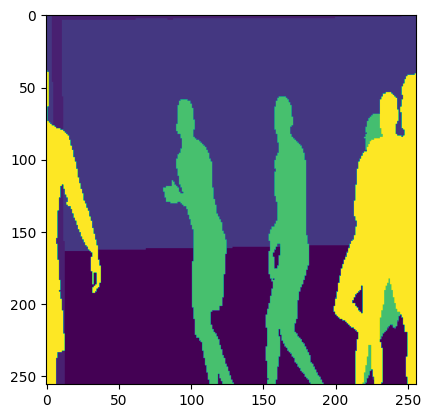

In [37]:
plt.imshow(train_images[0, :,:,0])
plt.imshow(train_masks[0])

In [54]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


1/1 [==============================] - 2s 2s/step


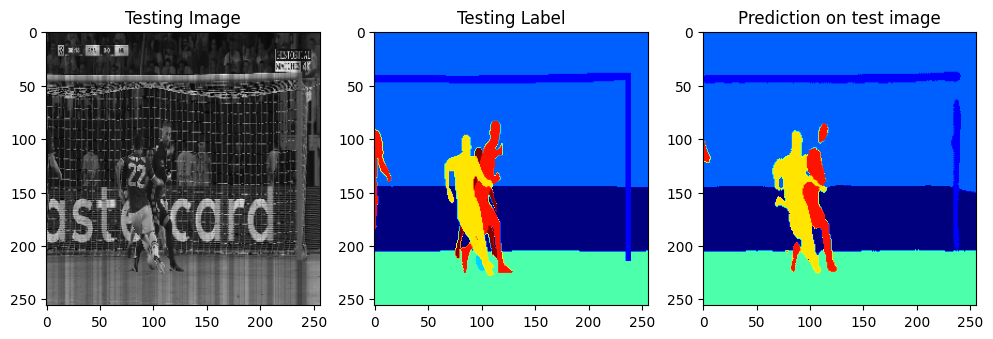

In [55]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()